In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib

from xgboost import plot_importance
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from sklearn.ensemble import GradientBoostingClassifier

#데이터 scaling
from sklearn.preprocessing import StandardScaler
#데이터 분할:train, test
from sklearn.model_selection import train_test_split
#분류 SVM
from sklearn.svm import SVC
#최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

#분류모델 평가 함수
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import accuracy_score, f1_score, precision_score,\
recall_score, roc_auc_score, confusion_matrix, classification_report

#한글 폰트 적용
matplotlib.rc("font", family = "Noto Sans CJK JP")

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('final_output.csv',encoding='cp949')
df

,chaju_id,credit_class,score_risk,gender,age,agegroup,job,edu,dwell_type,house_type,...,over_period,Pcard_over_amt,over_amt,loan_amt_final2,del_rate,loan_count,overdue_count,income_ind_grp,real_period,new_score_scaled
0,C-1001,C05,478,남성,30,30대,기능/노무직,대학교 졸업,자가,아파트,...,2.0,0.0,5700000.0,70300000.0,8.108108,9.0,1.0,300-399만원,222.0,253.033126
1,C-1002,C05,484,여성,66,60대,전업주부,초등학교 졸업,자가,아파트,...,0.0,0.0,0.0,3150000.0,0.000000,2.0,0.0,200-299만원,76.0,247.513828
2,C-1003,C05,478,남성,43,40대,판매/서비스직,대학교 졸업,자가,아파트,...,0.0,0.0,0.0,391000000.0,0.000000,5.0,0.0,500-599만원,234.0,309.232392
3,C-1004,C05,445,남성,28,20대,무직/기타,대학교 졸업,자가,아파트,...,0.0,0.0,0.0,590000.0,0.000000,2.0,0.0,100-199만원,90.0,342.965975
4,C-1005,C05,421,남성,52,50대,행정관리/전문직,대학교 졸업,자가,아파트,...,0.0,0.0,0.0,367200000.0,0.000000,4.0,0.0,300-399만원,264.0,289.420276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,C-2974,C05,401,여성,51,50대,기능/노무직,고등학교 졸업,자가,단독주택,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,100-199만원,141.0,NaN
1980,C-2988,C03,297,남성,70,70대,학생(재수생포함),대학교 재학,자가,아파트,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,600-699만원,93.0,NaN
1981,C-2997,C04,308,남성,37,30대,사무직,대학교 졸업,자가,아파트,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,300-399만원,80.0,NaN
1982,C-2998,C04,371,여성,50,50대,기능/노무직,고등학교 졸업,자가,아파트,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,100-199만원,181.0,NaN


In [3]:
df['income_ind_grp']

0       300-399만원
1       200-299만원
2       500-599만원
3       100-199만원
4       300-399만원
          ...    
1979    100-199만원
1980    600-699만원
1981    300-399만원
1982    100-199만원
1983    300-399만원
Name: income_ind_grp, Length: 1984, dtype: object

<AxesSubplot:xlabel='new_score_scaled', ylabel='Count'>

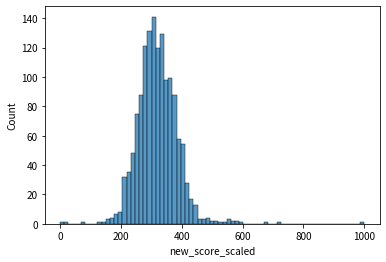

In [4]:
sns.histplot(df.new_score_scaled)

In [5]:
print(df.new_score_scaled.median())
print(df.new_score_scaled.mean())

317.0790210891756
320.9307363748174


In [6]:
df.new_score_scaled.isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
1979     True
1980     True
1981     True
1982     True
1983     True
Name: new_score_scaled, Length: 1984, dtype: bool

In [7]:
df['new_score_scaled'][1428]

264.20453237026777

In [8]:
df.loc[df['new_score_scaled']<df.new_score_scaled.median(),'label'] = 1
df.loc[df['new_score_scaled']>=df.new_score_scaled.median(),'label'] = 0

In [9]:
df['label']

0       1.0
1       1.0
2       1.0
3       0.0
4       1.0
       ... 
1979    NaN
1980    NaN
1981    NaN
1982    NaN
1983    NaN
Name: label, Length: 1984, dtype: float64

In [10]:
df.columns

Index(['chaju_id', 'credit_class', 'score_risk', 'gender', 'age', 'agegroup',
       'job', 'edu', 'dwell_type', 'house_type', 'marriage', 'income_home_grp',
       'expenditure_grp', 'child_cd', 'no_child', 'flag_priv_biz_cd',
       'card_count', 'card_period', 'loan_period', 'Pcard_loan_amt',
       'over_period', 'Pcard_over_amt', 'over_amt', 'loan_amt_final2',
       'del_rate', 'loan_count', 'overdue_count', 'income_ind_grp',
       'real_period', 'new_score_scaled', 'label'],
      dtype='object')

In [11]:
df = df.drop(['chaju_id', 'credit_class', 'score_risk','agegroup'],axis=1)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            1984 non-null   object 
 1   age               1984 non-null   int64  
 2   job               1984 non-null   object 
 3   edu               1984 non-null   object 
 4   dwell_type        1984 non-null   object 
 5   house_type        1984 non-null   object 
 6   marriage          1984 non-null   object 
 7   income_home_grp   1984 non-null   object 
 8   expenditure_grp   1984 non-null   object 
 9   child_cd          1984 non-null   object 
 10  no_child          1984 non-null   int64  
 11  flag_priv_biz_cd  1984 non-null   object 
 12  card_count        1984 non-null   float64
 13  card_period       1984 non-null   float64
 14  loan_period       1984 non-null   float64
 15  Pcard_loan_amt    1984 non-null   float64
 16  over_period       1984 non-null   float64


In [13]:
df.loc[(df.income_home_grp == '99만원 이하'),'income_home_grp'] = 50
df.loc[(df.income_home_grp == '100-199만원'),'income_home_grp'] = 150
df.loc[(df.income_home_grp == '200-299만원'),'income_home_grp'] = 250
df.loc[(df.income_home_grp == '300-399만원'),'income_home_grp'] = 350
df.loc[(df.income_home_grp == '400-499만원'),'income_home_grp'] = 450
df.loc[(df.income_home_grp == '500-599만원'),'income_home_grp'] = 550
df.loc[(df.income_home_grp == '600-699만원'),'income_home_grp'] = 650
df.loc[(df.income_home_grp == '700-799만원'),'income_home_grp'] = 750
df.loc[(df.income_home_grp == '800-899만원'),'income_home_grp'] = 850
df.loc[(df.income_home_grp == '900-999만원'),'income_home_grp'] = 950
df.loc[(df.income_home_grp == '1000만원 이상'),'income_home_grp'] = 2000
df['income_home_grp'] = df['income_home_grp'].astype(int)

In [14]:
df.loc[(df.income_ind_grp == '99만원 이하'),'income_ind_grp'] = 50
df.loc[(df.income_ind_grp == '100-199만원'),'income_ind_grp'] = 150
df.loc[(df.income_ind_grp == '200-299만원'),'income_ind_grp'] = 250
df.loc[(df.income_ind_grp == '300-399만원'),'income_ind_grp'] = 350
df.loc[(df.income_ind_grp == '400-499만원'),'income_ind_grp'] = 450
df.loc[(df.income_ind_grp == '500-599만원'),'income_ind_grp'] = 550
df.loc[(df.income_ind_grp == '600-699만원'),'income_ind_grp'] = 650
df.loc[(df.income_ind_grp == '700-799만원'),'income_ind_grp'] = 750
df.loc[(df.income_ind_grp == '800-899만원'),'income_ind_grp'] = 850
df.loc[(df.income_ind_grp == '900-999만원'),'income_ind_grp'] = 950
df.loc[(df.income_ind_grp == '1000만원 이상'),'income_ind_grp'] = 2000
df['income_ind_grp']  = df['income_ind_grp'].astype(int)

In [15]:
df.loc[(df.expenditure_grp == '99만원 이하'),'expenditure_grp'] = 50
df.loc[(df.expenditure_grp == '100-199만원'),'expenditure_grp'] = 150
df.loc[(df.expenditure_grp == '200-299만원'),'expenditure_grp'] = 250
df.loc[(df.expenditure_grp == '300-399만원'),'expenditure_grp'] = 350
df.loc[(df.expenditure_grp == '400-499만원'),'expenditure_grp'] = 450
df.loc[(df.expenditure_grp == '500-599만원'),'expenditure_grp'] = 550
df['expenditure_grp']  = df['expenditure_grp'].astype(int)

In [16]:
df_dummy = pd.get_dummies(df)
df_raw_y = df_dummy["label"]
df_raw_x = df_dummy.drop("label", axis = 1, inplace = False)

In [17]:
df_dummy.columns

Index(['age', 'income_home_grp', 'expenditure_grp', 'no_child', 'card_count',
       'card_period', 'loan_period', 'Pcard_loan_amt', 'over_period',
       'Pcard_over_amt', 'over_amt', 'loan_amt_final2', 'del_rate',
       'loan_count', 'overdue_count', 'income_ind_grp', 'real_period',
       'new_score_scaled', 'label', 'gender_남성', 'gender_여성', 'job_기능/노무직',
       'job_무직/기타', 'job_사무직', 'job_전업주부', 'job_판매/서비스직', 'job_학생(재수생포함)',
       'job_행정관리/전문직', 'edu_고등학교 재학', 'edu_고등학교 졸업', 'edu_대학교 재학',
       'edu_대학교 졸업', 'edu_대학원 재학', 'edu_대학원 졸업', 'edu_전문대학 재학', 'edu_전문대학 졸업',
       'edu_중학교 졸업', 'edu_초등학교 졸업', 'dwell_type_사택/기타', 'dwell_type_영구임대',
       'dwell_type_월세', 'dwell_type_자가', 'dwell_type_전세', 'house_type_기타',
       'house_type_단독주택', 'house_type_상가주택', 'house_type_아파트',
       'house_type_연립/다세대/빌라', 'house_type_오피스텔', 'marriage_기타(이혼/별거/사별)',
       'marriage_기혼', 'marriage_미혼', 'child_cd_N', 'child_cd_Y',
       'flag_priv_biz_cd_N', 'flag_priv_biz_cd_Y'],
      dtype

In [18]:
df_new = df_dummy.drop(['card_count', 'card_period', 'loan_period', 'Pcard_loan_amt',
       'over_period', 'Pcard_over_amt', 'over_amt', 'loan_amt_final2',
       'del_rate', 'loan_count', 'overdue_count', 'new_score_scaled',
       'real_period'],axis=1)

In [19]:
df_new

,age,income_home_grp,expenditure_grp,no_child,income_ind_grp,label,gender_남성,gender_여성,job_기능/노무직,job_무직/기타,...,house_type_아파트,house_type_연립/다세대/빌라,house_type_오피스텔,marriage_기타(이혼/별거/사별),marriage_기혼,marriage_미혼,child_cd_N,child_cd_Y,flag_priv_biz_cd_N,flag_priv_biz_cd_Y
0,30,950,150,0,350,1.0,1,0,1,0,...,1,0,0,0,0,1,1,0,1,0
1,66,250,50,3,250,1.0,0,1,0,0,...,1,0,0,0,1,0,0,1,0,1
2,43,550,150,2,550,1.0,1,0,0,0,...,1,0,0,0,1,0,0,1,1,0
3,28,550,50,0,150,0.0,1,0,0,1,...,1,0,0,0,0,1,1,0,1,0
4,52,550,250,2,350,1.0,1,0,0,0,...,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,51,450,150,2,150,NaN,0,1,1,0,...,0,0,0,0,1,0,0,1,1,0
1980,70,650,50,0,650,NaN,1,0,0,0,...,1,0,0,0,0,1,1,0,1,0
1981,37,350,150,2,350,NaN,1,0,0,0,...,1,0,0,0,1,0,0,1,1,0
1982,50,550,150,2,150,NaN,0,1,1,0,...,1,0,0,0,1,0,0,1,1,0


In [20]:
df_dummy

,age,income_home_grp,expenditure_grp,no_child,card_count,card_period,loan_period,Pcard_loan_amt,over_period,Pcard_over_amt,...,house_type_아파트,house_type_연립/다세대/빌라,house_type_오피스텔,marriage_기타(이혼/별거/사별),marriage_기혼,marriage_미혼,child_cd_N,child_cd_Y,flag_priv_biz_cd_N,flag_priv_biz_cd_Y
0,30,950,150,0,4.0,99.0,79.0,0.0,2.0,0.0,...,1,0,0,0,0,1,1,0,1,0
1,66,250,50,3,6.0,126.0,6.0,350000.0,0.0,0.0,...,1,0,0,0,1,0,0,1,0,1
2,43,550,150,2,2.0,50.0,79.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,1,1,0
3,28,550,50,0,1.0,25.0,5.0,0.0,0.0,0.0,...,1,0,0,0,0,1,1,0,1,0
4,52,550,250,2,3.0,75.0,40.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,51,450,150,2,3.0,72.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,1,0
1980,70,650,50,0,1.0,25.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,1,1,0,1,0
1981,37,350,150,2,1.0,1.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,1,1,0
1982,50,550,150,2,5.0,104.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,1,1,0


In [21]:
df_nthin = df_dummy.iloc[:1428,:]

In [22]:
df_nthin['new_score_scaled']

0       253.033126
1       247.513828
2       309.232392
3       342.965975
4       289.420276
           ...    
1423    389.468071
1424    345.134357
1425    344.159262
1426    255.539538
1427    339.602816
Name: new_score_scaled, Length: 1428, dtype: float64

In [23]:
df_thin = df_dummy.iloc[1429:,:]
df_thin

,age,income_home_grp,expenditure_grp,no_child,card_count,card_period,loan_period,Pcard_loan_amt,over_period,Pcard_over_amt,...,house_type_아파트,house_type_연립/다세대/빌라,house_type_오피스텔,marriage_기타(이혼/별거/사별),marriage_기혼,marriage_미혼,child_cd_N,child_cd_Y,flag_priv_biz_cd_N,flag_priv_biz_cd_Y
1429,22,450,150,0,1.0,25.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,1,0,1,0
1430,52,450,50,0,3.0,62.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,1,0,1,0
1431,26,450,50,0,1.0,11.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,1,0,1,0
1432,56,550,150,2,5.0,101.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,1,0
1433,53,350,150,1,6.0,103.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,51,450,150,2,3.0,72.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,1,1,0
1980,70,650,50,0,1.0,25.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,1,1,0,1,0
1981,37,350,150,2,1.0,1.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,1,1,0
1982,50,550,150,2,5.0,104.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,1,1,0


In [24]:
df_raw_y = df_nthin["label"]
df_raw_x = df_nthin.drop(['card_count',
       'card_period', 'loan_period', 'Pcard_loan_amt', 'over_period',
       'Pcard_over_amt', 'over_amt', 'loan_amt_final2', 'del_rate',
       'loan_count', 'overdue_count','real_period','label','new_score_scaled'],axis=1, inplace = False)

In [25]:
df_raw_x.columns

Index(['age', 'income_home_grp', 'expenditure_grp', 'no_child',
       'income_ind_grp', 'gender_남성', 'gender_여성', 'job_기능/노무직', 'job_무직/기타',
       'job_사무직', 'job_전업주부', 'job_판매/서비스직', 'job_학생(재수생포함)', 'job_행정관리/전문직',
       'edu_고등학교 재학', 'edu_고등학교 졸업', 'edu_대학교 재학', 'edu_대학교 졸업', 'edu_대학원 재학',
       'edu_대학원 졸업', 'edu_전문대학 재학', 'edu_전문대학 졸업', 'edu_중학교 졸업', 'edu_초등학교 졸업',
       'dwell_type_사택/기타', 'dwell_type_영구임대', 'dwell_type_월세', 'dwell_type_자가',
       'dwell_type_전세', 'house_type_기타', 'house_type_단독주택', 'house_type_상가주택',
       'house_type_아파트', 'house_type_연립/다세대/빌라', 'house_type_오피스텔',
       'marriage_기타(이혼/별거/사별)', 'marriage_기혼', 'marriage_미혼', 'child_cd_N',
       'child_cd_Y', 'flag_priv_biz_cd_N', 'flag_priv_biz_cd_Y'],
      dtype='object')

In [26]:
df_train_x, df_test_x, df_train_y, df_test_y  = train_test_split(df_raw_x,df_raw_y,test_size = 0.3)
xgb_final =  XGBClassifier(max_depth = 8, 
                          n_estimators = 600,
                          learning_rate= .1)
xgb_final.fit(df_train_x,df_train_y)
y_pred = xgb_final.predict(df_test_x)
print("Accuracy on training set:{:3f}".format(xgb_final.score(df_train_x,df_train_y)))
print("Accuracy on test set:{:3f}".format(xgb_final.score(df_test_x,df_test_y)))
print("Confusion matrix:\n{}".format(confusion_matrix(df_test_y,y_pred)))
print(classification_report(df_test_y,y_pred,digits=3))

[00:39:26] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy on training set:0.922923
Accuracy on test set:0.608392
Confusion matrix:
[[117  91]
 [ 77 144]]
              precision    recall  f1-score   support

         0.0      0.603     0.562     0.582       208
         1.0      0.613     0.652     0.632       221

    accuracy                          0.608       429
   macro avg      0.608     0.607     0.607       429
weighted avg      0.608     0.608     0.608       429



In [27]:
df_thin.columns

Index(['age', 'income_home_grp', 'expenditure_grp', 'no_child', 'card_count',
       'card_period', 'loan_period', 'Pcard_loan_amt', 'over_period',
       'Pcard_over_amt', 'over_amt', 'loan_amt_final2', 'del_rate',
       'loan_count', 'overdue_count', 'income_ind_grp', 'real_period',
       'new_score_scaled', 'label', 'gender_남성', 'gender_여성', 'job_기능/노무직',
       'job_무직/기타', 'job_사무직', 'job_전업주부', 'job_판매/서비스직', 'job_학생(재수생포함)',
       'job_행정관리/전문직', 'edu_고등학교 재학', 'edu_고등학교 졸업', 'edu_대학교 재학',
       'edu_대학교 졸업', 'edu_대학원 재학', 'edu_대학원 졸업', 'edu_전문대학 재학', 'edu_전문대학 졸업',
       'edu_중학교 졸업', 'edu_초등학교 졸업', 'dwell_type_사택/기타', 'dwell_type_영구임대',
       'dwell_type_월세', 'dwell_type_자가', 'dwell_type_전세', 'house_type_기타',
       'house_type_단독주택', 'house_type_상가주택', 'house_type_아파트',
       'house_type_연립/다세대/빌라', 'house_type_오피스텔', 'marriage_기타(이혼/별거/사별)',
       'marriage_기혼', 'marriage_미혼', 'child_cd_N', 'child_cd_Y',
       'flag_priv_biz_cd_N', 'flag_priv_biz_cd_Y'],
      dtype

In [28]:
df_thin= df_thin.drop(['card_count',
       'card_period', 'loan_period', 'Pcard_loan_amt', 'over_period',
       'Pcard_over_amt', 'over_amt', 'loan_amt_final2', 'del_rate',
       'loan_count', 'overdue_count','real_period','label','new_score_scaled'],axis=1, inplace = False)

In [29]:
y_pred2 = xgb_final.predict(df_thin)
y_pred2

array([0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
       1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 1.

In [30]:
len(y_pred2)

555

In [31]:
df_thin

,age,income_home_grp,expenditure_grp,no_child,income_ind_grp,gender_남성,gender_여성,job_기능/노무직,job_무직/기타,job_사무직,...,house_type_아파트,house_type_연립/다세대/빌라,house_type_오피스텔,marriage_기타(이혼/별거/사별),marriage_기혼,marriage_미혼,child_cd_N,child_cd_Y,flag_priv_biz_cd_N,flag_priv_biz_cd_Y
1429,22,450,150,0,450,1,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
1430,52,450,50,0,150,0,1,1,0,0,...,1,0,0,0,1,0,1,0,1,0
1431,26,450,50,0,250,0,1,0,0,1,...,0,0,1,0,0,1,1,0,1,0
1432,56,550,150,2,250,0,1,0,0,0,...,0,0,0,0,1,0,0,1,1,0
1433,53,350,150,1,150,0,1,0,0,0,...,0,1,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,51,450,150,2,150,0,1,1,0,0,...,0,0,0,0,1,0,0,1,1,0
1980,70,650,50,0,650,1,0,0,0,0,...,1,0,0,0,0,1,1,0,1,0
1981,37,350,150,2,350,1,0,0,0,1,...,1,0,0,0,1,0,0,1,1,0
1982,50,550,150,2,150,0,1,1,0,0,...,1,0,0,0,1,0,0,1,1,0


In [32]:
df_thin.reset_index(inplace=True)

In [33]:
for i in range(len(df_thin)):
    df_thin.loc[i,'pred'] = y_pred2[i]

In [34]:
df_thin

,index,age,income_home_grp,expenditure_grp,no_child,income_ind_grp,gender_남성,gender_여성,job_기능/노무직,job_무직/기타,...,house_type_연립/다세대/빌라,house_type_오피스텔,marriage_기타(이혼/별거/사별),marriage_기혼,marriage_미혼,child_cd_N,child_cd_Y,flag_priv_biz_cd_N,flag_priv_biz_cd_Y,pred
0,1429,22,450,150,0,450,1,0,0,0,...,0,0,0,0,1,1,0,1,0,0.0
1,1430,52,450,50,0,150,0,1,1,0,...,0,0,0,1,0,1,0,1,0,1.0
2,1431,26,450,50,0,250,0,1,0,0,...,0,1,0,0,1,1,0,1,0,1.0
3,1432,56,550,150,2,250,0,1,0,0,...,0,0,0,1,0,0,1,1,0,1.0
4,1433,53,350,150,1,150,0,1,0,0,...,1,0,0,1,0,0,1,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,1979,51,450,150,2,150,0,1,1,0,...,0,0,0,1,0,0,1,1,0,1.0
551,1980,70,650,50,0,650,1,0,0,0,...,0,0,0,0,1,1,0,1,0,0.0
552,1981,37,350,150,2,350,1,0,0,0,...,0,0,0,1,0,0,1,1,0,1.0
553,1982,50,550,150,2,150,0,1,1,0,...,0,0,0,1,0,0,1,1,0,1.0


In [36]:
df_thin[df_thin['pred'] ==1]

,index,age,income_home_grp,expenditure_grp,no_child,income_ind_grp,gender_남성,gender_여성,job_기능/노무직,job_무직/기타,...,house_type_연립/다세대/빌라,house_type_오피스텔,marriage_기타(이혼/별거/사별),marriage_기혼,marriage_미혼,child_cd_N,child_cd_Y,flag_priv_biz_cd_N,flag_priv_biz_cd_Y,pred
1,1430,52,450,50,0,150,0,1,1,0,...,0,0,0,1,0,1,0,1,0,1.0
2,1431,26,450,50,0,250,0,1,0,0,...,0,1,0,0,1,1,0,1,0,1.0
3,1432,56,550,150,2,250,0,1,0,0,...,0,0,0,1,0,0,1,1,0,1.0
6,1435,38,650,150,2,250,0,1,0,0,...,0,0,0,1,0,0,1,1,0,1.0
7,1436,46,550,50,2,250,0,1,0,0,...,0,0,0,1,0,0,1,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,1978,52,550,150,1,150,0,1,0,0,...,1,0,0,1,0,0,1,1,0,1.0
550,1979,51,450,150,2,150,0,1,1,0,...,0,0,0,1,0,0,1,1,0,1.0
552,1981,37,350,150,2,350,1,0,0,0,...,0,0,0,1,0,0,1,1,0,1.0
553,1982,50,550,150,2,150,0,1,1,0,...,0,0,0,1,0,0,1,1,0,1.0


254명이 유입되었다!

<AxesSubplot:xlabel='pred', ylabel='count'>

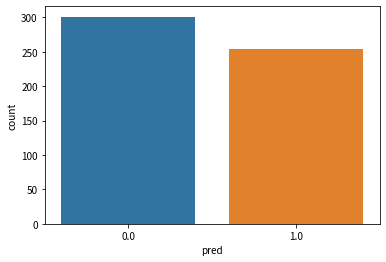

In [38]:
sns.countplot(x='pred',data=df_thin)

In [57]:
df_thin['pred'].value_counts()

0.0    301
1.0    254
Name: pred, dtype: int64

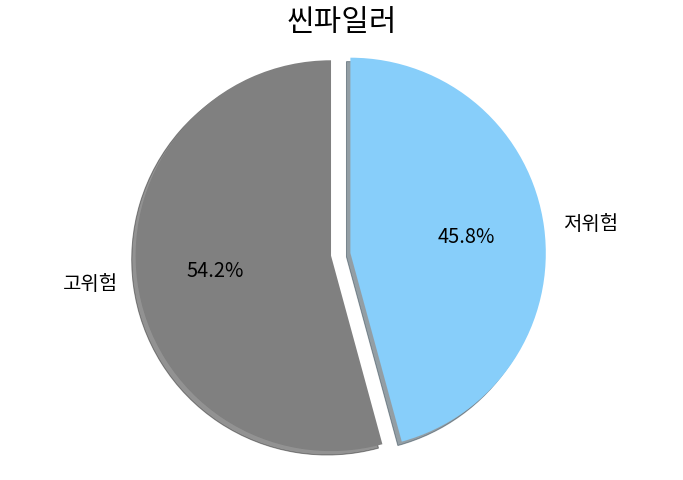

In [68]:
plt.rcParams['figure.figsize'] = [12, 8]
group_names = ['고위험', '저위험']

group_sizes = [301, 254]
group_colors = ['grey', 'lightskyblue']
group_explodes = (0.1, 0) # explode 1st slice

plt.pie(group_sizes, 
        explode=group_explodes, 
        labels=group_names, 
        colors=group_colors, 
        autopct='%1.1f%%', # second decimal place
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 20}) # text font size

plt.axis('equal') #  equal length of X and Y axis
plt.title('씬파일러', fontsize=30)
plt.show()

